In [2]:
from torchvision import models
resnet = models.resnet50(pretrained=True)

print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
import torch 

sample_x = torch.randn((1, 3, 255, 255))

out = resnet(sample_x)

out.shape

torch.Size([1, 1000])

In [ ]:
%cd stylegan3

import legacy

!wget "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-afhqcat-512x512.pkl" -O "model.pkl" #512x512 model is so slow so be aware

if model_name != "human":
  with open("model.pkl", "rb")as file:
      G = legacy.load_network_pkl(file)["G_ema"].to(device)
else:
  with open("stylegan_human_v2_512.pkl", "rb")as file:
      G = legacy.load_network_pkl(file)["G_ema"].to(device)

# Construct an inverse rotation/translation matrix and pass to the generator.  The
# generator expects this matrix as an inverse to avoid potentially failing numerical
# operations in the network.
if hasattr(G.synthesis, "input"):
  m = make_transform((0, 0), 0)
  m = np.linalg.inv(m)
  G.synthesis.input.transform.copy_(torch.from_numpy(m))

In [5]:
from stylegan3.generate import load_stylegan_network, generate_images

device = torch.device("cuda")
G = load_stylegan_network("../models/stylegan2-afhqwild-512x512.pkl", device)

Loading networks from ../models/stylegan2-afhqwild-512x512.pkl


In [ ]:
img = generate_images(G, device, 777)

img

In [8]:
import torch
import torch.nn as nn
from torchvision import models
from stylegan3.generate import load_stylegan_network, generate_images

class ResembleGAN(nn.Module):
    def __init__(self):
        super(ResembleGAN, self).__init__()

        self.resnet = models.resnet50(pretrained=True)
        self.stylegan = torch.load("./models/stylegan2-afhqwild-512x512.pkl")

        self.prepare_network()

    def prepare_network(self):
        for para in self.stylegan.parameters():
            para.requires_grad = False
        
    def forward(self, x):
        x = x.reshape(x.shape[0], 3, 255, 255)

        latent_vector = self.resnet(x)

        estimation = self.stylegan(latent_vector)

        return estimation, latent_vector

In [9]:
def l2_loss_function(y, y_hat):
    criterion = nn.MSELoss()
    loss = criterion(y, y_hat)

    return loss 

## Add a L1-penalty to the latent code to keep it close to StyleGan's concept of "face"
## Combination of the VGG semnatic loss + raw-pixel loss
## MS-SIM perceptual loss
## learning rate decay during optimization

In [1]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torchvision.transforms as T

class CustomDataset(Dataset):
    def __init__(self, x, y, transform=T.ToTensor()):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        target_x = self.x[idx]
        target_y = self.y[idx]

        img_x = Image.open(target_x)
        img_y = Image.open(target_y)

        transformed_img_x = self.transform(img_x)
        transformed_img_y = self.transform(img_y)

        return transformed_img_x, transformed_img_y

In [3]:
import glob

x = glob.glob("../dataset/after/human/*")
y = glob.glob("../dataset/after/animal/*")


def sort_key(path):
    return int(path.split("\\")[-1].split("_")[-1].split(".")[0])

x = sorted(x, key=lambda x: sort_key(x))
y = sorted(y, key=lambda y: sort_key(y))

x[:5], y[:5]

(['../dataset/after/human\\train_0.jpg',
  '../dataset/after/human\\train_1.jpg',
  '../dataset/after/human\\train_2.jpg',
  '../dataset/after/human\\train_3.jpg',
  '../dataset/after/human\\train_4.jpg'],
 ['../dataset/after/animal\\train_0.jpg',
  '../dataset/after/animal\\train_1.jpg',
  '../dataset/after/animal\\train_2.jpg',
  '../dataset/after/animal\\train_3.jpg',
  '../dataset/after/animal\\train_4.jpg'])

In [4]:
from torch.utils.data import random_split

dataset = CustomDataset(x, y)
dataset_size = len(dataset)
train_size = int(dataset_size*0.8)
validation_size = dataset_size - train_size

train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

print(f"Training Data Size: {train_size}")
print(f"Validation Data Size: {validation_size}")

Training Data Size: 102
Validation Data Size: 26


In [14]:
BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

train_size = len(train_dataloader)

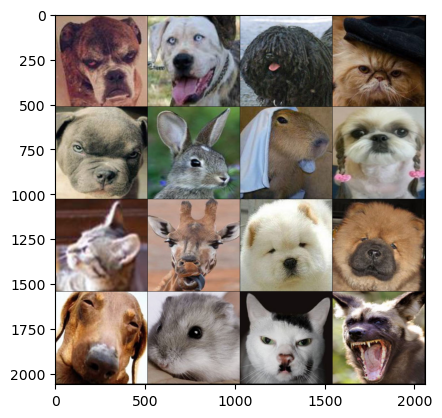

In [15]:
import matplotlib.pyplot as plt
import torchvision

for data in validation_dataloader: 
    original_img, animal_face = data 

    plt.imshow(torchvision.utils.make_grid(original_img, nrow=4).permute(1, 2, 0))
    plt.imshow(torchvision.utils.make_grid(animal_face, nrow=4).permute(1, 2,0))
    plt.show()

    break

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")

Device: cuda


In [ ]:
import torch.optim as optim

model = ResembleGAN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.025, weight_decay=0.01)

In [ ]:
import torchvision
from datetime import datetime 
import os 

nb_epochs = 1500

def validation(epoch):
    for (human_face, original_animal_face) in validation_dataloader:
        human_face, original_animal_face = human_face.to(device), original_animal_face.to(device)

        predicted_animal_face = model(original_animal_face)

        original_grid = torchvision.utils.make_grid(original_animal_face, nrow=4).permute(1, 2, 0)
        predicted_grid = torchvision.utils.make_grid(predicted_animal_face, nrow=4).permute(1, 2, 0)
        
        folder_name = str(datetime.now())

        output_dir = os.path.join("../output/",folder_name)

        original_grid.save(os.path.join(output_dir, "input_image.png"))
        predicted_animal_face.save(os.path.join(output_dir, "predicted_animal_face.png"))

        break
                        

for epoch in range(nb_epochs):
    losses = 0

    for batch_idx, (x, y) in enumerate(train_dataloader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        y_pred,latent_vecotr = model(y)

        loss = l2_loss_function(y, y_pred)
        losses += loss.item()

        loss.backward()
        optimizer.step()

    losses /= train_size
   
    print(f"Epoch: {epoch}/{nb_epochs} | Training Loss: {losses}")      

    if epoch % 10 == 0:
        validation(epoch)